# Transfer Learning

In this exercise we  have a closer look at transfer learning, which means that we will use a model pre-trained for another purpose. Transfer learning is used in almost all of today's applications of machine learning because it enables you to achieve good performance even on rather small datasets. We intentionally use the same dataset you already used from the CNN notebook, the [messy vs clean](https://www.kaggle.com/cdawn1/messy-vs-clean-room?) dataset from Kaggle that contains of a few samples (106 samples). Because of the small amount of data our models trained before weren't able to achieve reasonable performance. Let us see whether transfer learning makes this any better.

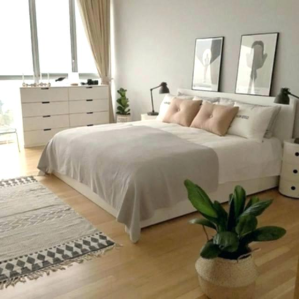

### Import Libraries

If you get an error saying that a particular library is not found, you can install it using `pip install [library]`. This notebook uses TensorFlow version 2.3.1 if you have installed an older version, make sure to update it.

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from collections import Counter

from ipywidgets import interact
import ipywidgets as widgets

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD, Adam

import warnings
warnings.filterwarnings("ignore")

### Helper Method

In [ ]:
def show_history_plots_of_trained_model(history, epochs, fill_between=False):
    """
    This method plots training and validation accuracy and loss.
    """
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range = range(epochs)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="training accuracy")
    plt.plot(epochs_range, val_acc, label="validation accuracy")
    if fill_between:
        plt.fill_between(epochs_range, acc, val_acc, color = "lightpink", alpha = 0.4, 
                      hatch = "-", label="difference")
    plt.legend(loc="lower right")
    plt.title("training and validation accuracy")
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="training loss")
    plt.plot(epochs_range, val_loss, label="validation loss")
    if fill_between:
        plt.fill_between(epochs_range, loss, val_loss, color = "lightpink", alpha = 0.4, 
                         hatch = "-", label="difference")
    plt.legend(loc="upper right")
    plt.title("training and validation loss")
    plt.show()

### Define Parameters

We set the values for training parameters, i.e. how many epochs the model should be trained (one epoch corresponds to one iteration over the complete training set) and the batch size (number of samples used for gradient computation).

In [ ]:
epochs     = 30
batch_size = 16
initial_lr = 0.0001

img_height = 128
img_width  = 128

# if you run into path problems when on Windows, 
# you'll need to exchange the "/" for "\"
train_path = os.getcwd() + "/data/train"
test_path  = os.getcwd() + "/data/test"

num_classes = 2

SEED = 42

## Loading the Messy vs Clean Room Dataset 

For loading the dataset we can directly use TensorFlow's `tf.data.Dataset` API, which is a neat way to store your dataset because it provides you with many utility methods. Some of them you will see during this exercise. To load an image dataset from the directory, we can use the `image_dataset_from_directory()` method. First, we need to pass the method the path of the dataset. Second, we can give some optional arguments to the method, which helps us to create the dataset without much effort. For example, we can specify the `image_size` which automatically resizes the loaded images. You can read more about the method and its parameters [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory). We will load the training dataset (`train_ds`) first, by setting `subset` to `training`. Afterwards, the validation dataset is loaded (`val_ds`), by setting `subset` to `validation`. For both datasets, a validation split is needed, which states how much of the dataset is used for training and how much for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(img_height, img_width),
    batch_size=batch_size)

In [ ]:
# load the validation data
#val_ds = tf.keras.preprocessing.image_dataset_from_directory(...)

*Click on the dots to display the solution*

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(img_height, img_width),
    batch_size=batch_size)

We will not examine the dataset again but just plot some random images from the dataset.

In [ ]:
# Specify the figure size of the individual plot
plt.figure(figsize=(10, 10))

# Loop over the dataset by taking one image and label at a time
for images, labels in train_ds.take(1):
    for i in range(9):
        # We display a 3x3 grid of images
        img = images[i].numpy().astype("uint8")
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

## Create the Model

TensorFlow makes it easy to use pre-trained models using `tf.keras.applications`. TF provides some of the state-of-the-art models already implemented and also with pre-trained weights, such as ResNet, MobileNet, EfficientNet and many more. In our exercise, we will use `MobileNetV2`, which is a relatively lightweight architecture introduced in the paper [MobileNetV2: Inverted Residuals and Linear Bottlenecks (CVPR 2018)](https://arxiv.org/abs/1801.04381). We use the weights trained on the `ImageNet` dataset, a very general image dataset consisting of 1000 different categories. It can thus be assumed that the model learned some very general image features suitable also for our purposes.

As a first step, we will freeze the entire pre-trained `MobileNetV2` model, which enables us to only train the dense layer on top of the model. It is important to note that when using pre-trained weights, you should never train the entire model when adding a new randomly initialized part on top of it. Because the upper part is randomly initialized, the gradients will be relatively high. Therefore, the training process will destroy the already learnt features. In case you do want to train the entire model again, as we will in the second part of the exercise, you should first pre-train only the top layer and only then you can train the entire model.

For our base model, which can also be thought of as a feature extractor, we need to specify arguments such as if we want to include the top layers of the model (`include_top`), which is the last dense layer, used for the ImageNet classification task. And since we want to use our own fully connected layer, we set it to `False`. We further specify the input shape (`input_shape`) of our model. And finally, we can set the weights (`weights`) we want to use. When running the command below for the first time, you will see that it will download the weights.

In [ ]:
#base_model = tf.keras.applications.MobileNetV2(...)

*Click on the dots to display the solution*

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

Because we will first use our model as a pure feature extractor and only train the last layers of our model, we  freeze the layers of the `base_model` to ensure that the parameters will not be updated.

In [ ]:
# freeze the model

*Click on the dots to display the solution*

In [ ]:
base_model.trainable = False

We can check how many parameters our base model has by calling the `summary()` method. Here we can see what the freezing from above did. You can see that our model only has `Non-trainable params` as a consequence of `trainable=False`.

In [ ]:
# display the summary of the model

*Click on the dots to display the solution*

In [ ]:
base_model.summary()

Now we can build our classification head, which consists of a fully connected layer followed by a single pooling layer and the output layer. Since we have all our building blocks together, we can now build our model. Observe in the summary that our model has only about 160'000 trainable parameters - significantly lower than in our CNN exercise (approx. 1.6 million).

In [ ]:
#model = models.Sequential()

# add our feature extractor model (MobileNetV2)
#model.add(base_model)

# add our classification head
#model.add(layers.Dense(128, activation="relu"))
#model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Dense(num_classes, activation='softmax'))

# Define Adam with the defined learning rate
# opt = ...

# Define the loss function
# loss = ...

# Compile the model, using an optimizer, a loss function and desired metrics
#model.compile(...)

# Print a summary of the created model
# ...

*Click on the dots to display the solution*

In [ ]:
model = models.Sequential()

# add our feature extractor model (MobileNetV2)
model.add(base_model)

# add our classification head
model.add(layers.Dense(128, activation="relu"))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(num_classes, activation='softmax'))

# Define Adam with the defined learning rate
opt = Adam(lr=initial_lr)

# Define the loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile the model, using an optimizer, a loss function and desired metrics
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

# Print a summary of the created model
model.summary()

As usual, the model can be trained using `fit`, where we specify the training dataset (`train_ds`) as well as the validation dataset (`val_ds`) along with the number of epochs the model should be trained.

In [ ]:
start = time.time()

# Fit the model on the training dataset and validate it on the validation set
#history = model.fit(...)

end = time.time()
print("Training took {0:.2f} seconds".format(end-start))

*Click on the dots to display the solution*

In [ ]:
start = time.time()

# Fit the model on the training dataset and validate it on the validation set
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    shuffle=True
)

end = time.time()
print("Training took {0:.2f} seconds".format(end-start))

We plot accuracy and loss of the model on training and validation set.

In [ ]:
show_history_plots_of_trained_model(history, epochs=epochs, fill_between=True)

No doubt the model is still overfitting, but not as much as before, which is very good for such a small dataset. We can now try to further optimize our model, by now also fine-tuning some of the earlier layers of our `base_model`. This enables our model to learn features specific for the new dataset. To do so, we will need to recompile our model, since whenever you change the properties of your model, such as the `trainable` parameters, the change will only take effect after the compilation of the model. To freeze  individual layers, we will first set the entire `base_model` to trainable and then freeze the layers up to a specific number. Since our model consists of 155 layers, we can e.g. unfreeze all the layers above layer 130.

In [ ]:
# how many layers does our base model have?
# ...

*Click on the dots to display the solution*

In [ ]:
print('Layers in our base model: %s' % len(model.layers[0].layers))

In [ ]:
# fine tune the layers above this one
fine_tune_at = 130

# unfreeze all layers
model.layers[0].trainable = True

# freeze all layers below the fine tune layer
for layer in model.layers[0].layers[:fine_tune_at]:
    layer.trainable = False

Now we will recompile our model and print the summary. It is now a lot bigger than before so that we better lower the learning rate. Otherwise, our model would overfit even more and destroy the already learnt filters. We can see that the number of trainable parameters is now much bigger than before.

In [ ]:
# Define stochastic gradient descent with a defined learning rate
#opt = Adam(lr=initial_lr/10)

# Compile the model, using an optimizer, a loss function and desired metrics
#model.compile(...)

# Print a summary of the created model
# ...

*Click on the dots to display the solution*

In [ ]:
# Define stochastic gradient descent with a defined learning rate
opt = Adam(lr=initial_lr/10)

# Compile the model, using an optimizer, a loss function and desired metrics
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

# Print a summary of the created model
model.summary()

We train the model again and check its accuracy.

In [ ]:
start = time.time()

# Fit the model on the training dataset and validate it on the validation set
#history = model.fit(...)

end = time.time()
print("Training took {0:.2f} seconds".format(end-start))

*Click on the dots to display the solution*

In [ ]:
start = time.time()

# Fit the model on the training dataset and validate it on the validation set
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    shuffle=True
)

end = time.time()
print("Training took {0:.2f} seconds".format(end-start))

In [ ]:
show_history_plots_of_trained_model(history, epochs=epochs, fill_between=True)

We can see that the model does not benefit for the fine-tuning, mostly because the dataset is just too small. Nevertheless, we saw that by using transfer learning, we were able to improve our model performance by quite a bit. Now the only thing that is left to do is to use it on unseen images.

# Test the Model on unseen Data

We can now use the trained model and feed it unseen images to see how it performs. We will use the test set for this, which the model has not seen before, neither in training nor at validation time.

In [ ]:
test_images = glob(os.path.join(test_path, "*.png"))

@interact(test_image=test_images)
def predict_test_image(test_image):
    img = keras.preprocessing.image.load_img(test_image, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    txt = "clean prob: {:.3}% \n messy prob: {:.3}%".format( 100*score[0], 100*score[1])
    
    fig = plt.figure()
    plt.imshow(img)
    fig.suptitle(txt, fontsize = 14)
    plt.axis('off')
    plt.show()

# Assignment

> Answer now the Illias Quiz 09B Transfer Learning